<a href="https://colab.research.google.com/github/hkim07/BA865/blob/master/BA865_HW_03_HK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW 03 - Create a word2vec model

<font color=blue size=4>
Before you submit this assignment, please carefully read these submission instructions. You must name this .ipynb file:
<br><br>
yourlastname_yourfirstname_HW3.ipynb
<br><br>
You must turn in this assignment by uploading the 
.ipynb file to the assignment on questrom tools. You will also need to print out a hard copy of this notebook (File->Print from colab) with the output from running all the code cells, and hand it in on the class following the due date. Do not email me the file.
<br><br>
Points will be deducted for improper submission!
</font>

For this assignment, by using the Pytorch library, we will create a word2vec model that infers contexts of words. Word2vec is first introduced in 2013 by Mikolov et al. at Google (https://arxiv.org/pdf/1301.3781.pdf, https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) and has been a popular machine learning model implemented in real cases. 

https://blog.acolyer.org/2016/04/21/the-amazing-power-of-word-vectors/ is a great overview of word2vec. Please read the blog carefully before you create a word2vec model for this assignment. Specifically, you will build a "Continuous Bag-of-Words Model (CBOW)" model. CBOW predicts a target word from its neighbors' contexts. The following Youtube videos also explain the concept of the CBOW model.
- https://www.youtube.com/watch?v=UqRCEmrv1gQ
- https://www.youtube.com/watch?v=gQddtTdmG_8 


<img src="https://i2.wp.com/www.stokastik.in/wp-content/uploads/2017/04/Screen-Shot-2017-05-16-at-8.48.52-PM.png?w=596">

[CBOW structure from http://www.stokastik.in/understanding-word-vectors-and-word2vec/]

Your task is to create a CBOW class called `CBOW`. `CBOW` has the following properties under the structure given at the figure above.

- `vocab_size` - Size of vocabulary($V$). Note that vocabulary is a set of unique words in a corpus and corpus is a set of texts
- `embed_dim` - Dimension of embedding vector
- `window_size` - Size of window. If a target word is $t$, CBOW model uses embedding vectors of words between ($t$-window_size) and ($t$+window_size) to predict the target word
- `hidden_dim` - Dimension of the hidden layer ($N$)

`CBOW` consists of three layers.

- `embedding` - An embedding layer that is initialized with `torch.nn.Embedding`
- `fc1` - A linear transformation that connects the embedding layer to the hidden layer. `torch.nn.functional.relu` activation should be applied to the output of `fc1`.
- `fc2` - A linear transformation that connects the activation of `fc1` to a tensor of length `vocab_size`. 

Input of `CBOW` is a tensor of length (2 * `window_size`). Input's elements are indices of neighboring words of the target word. You need to convert neighboring words into a tensor of word indices. Once you make a tensor of word indices, use this input to slice embedding vectors from `self.embedding` and train your model to reduce `torch.nn.CrossEntropyLoss` for the output of `fc2` and the index of the target word.

We will use restaurant customer reviews for this assignment - https://www.kaggle.com/vigneshwarsofficial/reviews/. **Do not change the code block below**. Use `cleaned_text` to learn word contexts.

In [0]:
import pandas as pd
import string

def clean_text(text):    
    x = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
    x = x.lower().split() # lower case and split by whitespace to differentiate words
    return x

example_text = pd.read_csv('https://raw.githubusercontent.com/hkim07/data/master/hw3.csv')
cleaned_text = example_text.Review[:100].apply(clean_text)

Train your CBOW model for 100 epochs with `embed_dim`=100, `window_size`=2, and `hidden_dim`=30. 
- Do not split the data into training and test sets. 
- Use the SGD optimizer with learning rate = 0.001.
- Save loss at every epoch. 

## Create a CBOW Class

In [0]:
#INSERT YOUR CODES HERE

In [2]:
import string, itertools
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import Counter

vocab = list(itertools.chain(*cleaned_text))
vocab = set(vocab)
print("The size of vocabulary is", len(vocab))

# dictionary to get word index
word_to_index = {word: i for i, word in enumerate(vocab)}

# Parameters
VOCAB_SIZE = len(vocab)
EMBED_DIM = 100
WINDOW_SIZE = 2
HIDDEN_DIM = 30
N_EPOCHS = 100

The size of vocabulary is 483


In [0]:
"""
[References]
https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html
https://github.com/jojonki/word2vec-pytorch/blob/master/word2vec.ipynb
"""

def make_cbow_data(text, window_size):
    cbow_data = []
    for i in range(window_size, len(text)-window_size):
        # format: (2*window_size - neighboring words, one target word) 
        cbow_data.append((text[i-window_size:i] + text[i+1:i+window_size+1], text[i])) 
    return cbow_data

cbow_data = [make_cbow_data(x, window_size = WINDOW_SIZE) for x in cleaned_text]


class CBOW(nn.Module):

    def __init__(self, vocab_size, embed_dim, window_size, hidden_dim):
        super(CBOW, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, sparse=True)
        self.fc1 = nn.Linear(2*window_size*embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x):
        x = self.embedding(x).view((1,-1))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Train the CBOW model

In [0]:
#INSERT YOUR CODES HERE

In [4]:
def train_cbow(data, n_epochs=1):
    model = CBOW(VOCAB_SIZE, EMBED_DIM, WINDOW_SIZE, HIDDEN_DIM)
    print(model) # print model structure
    losses = []
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001)    
    for i in range(n_epochs):
        total_loss = 0.0
        for sent in data:
            for context, target in sent:
                model.zero_grad() # gradients should not be accumulated
                input = torch.tensor([word_to_index[w] for w in context])
                output = model.forward(input)
                loss = loss_func(output, torch.tensor([word_to_index[target]], dtype=torch.long))
                loss.backward() # back propagation
                optimizer.step() # update parameters
                total_loss += loss.item()
        losses.append(total_loss)
        if i%10==9: print(total_loss)
    return model, losses

%time trained_model, trained_losses = train_cbow(cbow_data, n_epochs=N_EPOCHS)

CBOW(
  (embedding): Embedding(483, 100, sparse=True)
  (fc1): Linear(in_features=400, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=483, bias=True)
)
3606.846691250801
2796.7844499647617
2150.0482067093253
1580.1751106828451
1081.6504763355479
681.6839353749529
404.1367898671888
238.20048379723448
148.49916994571686
101.07532627956243
CPU times: user 52.3 s, sys: 3.14 s, total: 55.4 s
Wall time: 56.1 s


## Plot losses by epochs (x-axis: epoch, y-axis: loss)

In [0]:
#INSERT YOUR CODES HERE

Text(0, 0.5, 'Loss')

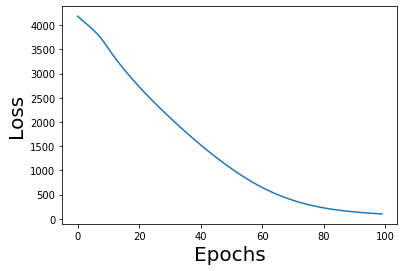

In [5]:
plt.plot(range(len(trained_losses)), trained_losses)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)

## Print five most similar words with the word "delicious"

You can access embedding vectors through `model.embedding.weight.data`. Find five most similar words with the word "delicious" by calculating cosine similarity between the embedding vector of "delicious" and embedding vectors of other words. 

In [0]:
#INSERT YOUR CODES HERE

In [6]:
mat = trained_model.embedding.weight.data.numpy()
obs_ix = word_to_index['delicious']
obs_vec = trained_model.embedding.weight.data[obs_ix]

from sklearn.metrics.pairwise import cosine_similarity

sims = []
listed_vocab = list(vocab)
obs_sim = cosine_similarity(mat)[obs_ix]
for i in range(len(listed_vocab)):
    sims.append([listed_vocab[i], obs_sim[i]])

sorted(sims, key=lambda x: x[1], reverse=True)[1:6]

[['care', 0.26426995],
 ['meh', 0.25803915],
 ['six', 0.23708118],
 ['also', 0.22749554],
 ['ripped', 0.22527032]]

While the model learns contexts as embedding vectors, the model still does perform badly. This is mainly due to the lack of data. Google trained a word2vec model based on large-scale data (about 100 billion words), and this model captures similarity between words well. You can find the pretrained model at https://code.google.com/archive/p/word2vec/.